In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
import pickle

plt.style.use('seaborn')

NOTE TO THE READER: 

Before going through this notebook, I kindly recommend reading the following documents: a (link) and b (link). These documents will provide the relevant information regarding variables and the overall goal of the project, and therefore, make this analysis more coherent.

In [139]:
df = pd.read_csv('SBAnational.csv', index_col= 'LoanNr_ChkDgt', parse_dates=['ApprovalDate','ChgOffDate', 'DisbursementDate'])

C:\Users\Vanja\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [140]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 899164 entries, 1000014003 to 9996003010
Data columns (total 26 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Name               899150 non-null  object        
 1   City               899134 non-null  object        
 2   State              899150 non-null  object        
 3   Zip                899164 non-null  int64         
 4   Bank               897605 non-null  object        
 5   BankState          897598 non-null  object        
 6   NAICS              899164 non-null  int64         
 7   ApprovalDate       899164 non-null  datetime64[ns]
 8   ApprovalFY         899164 non-null  object        
 9   Term               899164 non-null  int64         
 10  NoEmp              899164 non-null  int64         
 11  NewExist           899028 non-null  float64       
 12  CreateJob          899164 non-null  int64         
 13  RetainedJob        899164 non-n

In [141]:
# dependent variable

df.dropna(subset=['MIS_Status'], inplace=True)

### First-to-go columns:

In [142]:
df.drop(columns= 'ChgOffDate', inplace = True) # too many null values

In [143]:
# columns that won't be useful at first glance (text and cannot see how they can be turned to either category or number)

df.drop(columns = ['Name', 'Zip', 'City', 'Bank', 'FranchiseCode'], inplace=True)

In [144]:
# from loan approval point, disbursement date, and approval date do not create valid variables

df.drop(columns = ['DisbursementDate', 'ApprovalDate'], inplace=True)

### Binary variables:

In some of the below columns there are undefined values as well as bad data. I will map according to the variable definitions and check wether it increases the number of null values. Depending on the results, columns will stay or go.

In [145]:
df_bin = df[['NewExist', 'RevLineCr', 'LowDoc', 'UrbanRural']].copy(deep=True)
print(df[['NewExist', 'RevLineCr', 'LowDoc', 'UrbanRural']].info(),'\n')

df['UrbanRural'] = df['UrbanRural'].map({1.0: 0, 2.0: 1})
df['NewExist'] = df['NewExist'].map({1.0: 0, 2.0: 1})
df['RevLineCr'] = df['RevLineCr'].map({'N': 0, 'Y': 1}) 
df['LowDoc'] = df['LowDoc'].map({'N': 0, 'Y': 1}) 
df['MIS_Status'] = df['MIS_Status'].map({'CHGOFF': 0, 'P I F': 1})

print(df[['NewExist', 'RevLineCr', 'LowDoc', 'UrbanRural']].info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 897167 entries, 1000014003 to 9996003010
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   NewExist    897033 non-null  float64
 1   RevLineCr   892647 non-null  object 
 2   LowDoc      894589 non-null  object 
 3   UrbanRural  897167 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 34.2+ MB
None 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 897167 entries, 1000014003 to 9996003010
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   NewExist    896005 non-null  float64
 1   RevLineCr   619912 non-null  float64
 2   LowDoc      891168 non-null  float64
 3   UrbanRural  574341 non-null  float64
dtypes: float64(4)
memory usage: 34.2 MB
None


RevLineCr and UrbanRural are showing a significant increase as well as a high percentage of missing values. Due to this reason, I will drop both columns.

In [146]:
df.drop(columns = ['UrbanRural', 'RevLineCr'], inplace=True)

### Should-be numerical variables:

In [147]:
for column in ('GrAppv', 'SBA_Appv', 'DisbursementGross', 'BalanceGross', 'ChgOffPrinGr'):
    df[column] = df[column].apply(lambda x: x.replace('$',''))
    df[column] = df[column].apply(lambda x: x.replace(' ',''))
    df[column] = df[column].apply(lambda x: x.replace(',',''))
    df[column] = df[column].astype('float')

In [148]:
df_numerical = df[['GrAppv', 'SBA_Appv', 'DisbursementGross', 'BalanceGross', 'ChgOffPrinGr']]
df_numerical.head()

,GrAppv,SBA_Appv,DisbursementGross,BalanceGross,ChgOffPrinGr
LoanNr_ChkDgt,,,,,
1000014003,60000.0,48000.0,60000.0,0.0,0.0
1000024006,40000.0,32000.0,40000.0,0.0,0.0
1000034009,287000.0,215250.0,287000.0,0.0,0.0
1000044001,35000.0,28000.0,35000.0,0.0,0.0
1000054004,229000.0,229000.0,229000.0,0.0,0.0


In [149]:
# my first observation: Gross Approved is equal (or almost equal) to Disbursment Gross, lets check

df[df_numerical['GrAppv'] - df_numerical['DisbursementGross'] == 0].shape[0]

687882

In [150]:
# to many identical values, drop one of the columns

df.drop(columns='DisbursementGross', inplace=True)

In [151]:
# now lets check columns BalanceGross and ChgOffPrinGr

print(df[df['BalanceGross']==0].shape[0])
print(df[df['ChgOffPrinGr']==0].shape[0])

897153
735412


In [152]:
# too many values are zero

df.drop(columns=['BalanceGross','ChgOffPrinGr'],inplace=True)

### Text columns:

In [153]:
df_text = df[['NAICS', 'ApprovalFY', 'State', 'BankState']]
df_text.head()

,NAICS,ApprovalFY,State,BankState
LoanNr_ChkDgt,,,,
1000014003,451120,1997,IN,OH
1000024006,722410,1997,IN,IN
1000034009,621210,1997,IN,IN
1000044001,0,1997,OK,OK
1000054004,0,1997,FL,FL


In [154]:
df.shape

(897167, 13)

As the state could be a valuable predictor, I'll try to include it in the model. In order to reduce the number of categories, the idea is to make separate categories for the states with the highest amount of loans and the rest to put in one category.

In [155]:
unique, counts = np.unique(df['State'].dropna().values, return_counts=True)
states = dict(zip(counts, unique))
sorted_states = sorted(states.items(), reverse=True)
sorted_states[:4]  # don't want more than 5 dummie variables (4 for these + 1 for other countries)


[(130488, 'CA'), (70401, 'TX'), (57394, 'NY'), (41192, 'FL')]

In [156]:
def state_map(string):
    if string in [x[1] for x in sorted_states[:4]]:
        return string
    else:
        return 'Remaining states'

df['State'] = df['State'].apply(state_map)

<AxesSubplot:>

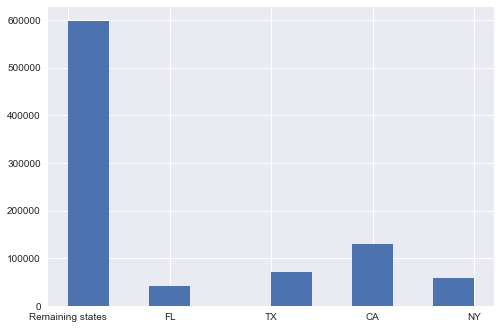

In [157]:
df['State'].hist() 

My process of thought is that in order to use this predictor, I should either include more states or find a better way to group them. I must say that first option doesn't sound appealing as it will significantly increase the number of columns. Regarding the second option, as suggested in the mentioned pdf file, there could be a reasonable way to group the states. However, this approach would require a separate analysis. Therefore, considering tradeoff time-contribution, I will drop this column now and in the reality of not satisfying model score, I'll revise my decision.

In [158]:
df.drop(columns = 'State', inplace=True)

In [159]:
# no point in having this

df.drop(columns='BankState', inplace=True)

In [160]:
# too many sectors to classify

df.drop(columns='NAICS', inplace=True)

In [161]:
df.head()

,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,LowDoc,MIS_Status,GrAppv,SBA_Appv
LoanNr_ChkDgt,,,,,,,,,,
1000014003,1997,84,4,1.0,0,0,1.0,1,60000.0,48000.0
1000024006,1997,60,2,1.0,0,0,1.0,1,40000.0,32000.0
1000034009,1997,180,7,0.0,0,0,0.0,1,287000.0,215250.0
1000044001,1997,60,2,0.0,0,0,1.0,1,35000.0,28000.0
1000054004,1997,240,14,0.0,7,7,0.0,1,229000.0,229000.0


In [162]:
# in ApprovalIFY there are both string and integer, have to deal with that

def str_int(item):
    if type(item) == str:
        for char in item:
            if not(char.isdigit()):
                item = item.replace(char,'')
        return int(item)
    else:
        return item

df['ApprovalFY'] = df['ApprovalFY'].apply(str_int)

In [163]:
# goal is to separate loans before and after economic crisis

(df['ApprovalFY']>=2007).sum()/df['ApprovalFY'].shape[0]

0.18764176569133728

In [164]:
df['ApprovalFY'] = np.where(df['ApprovalFY']>=2007, 1, 0) 

I am not sure whether to include this predictor as for all futher loans, ApprovalFY will be mapped as 1. However, I would like to see how much impact the same variable will have on model accurancy.

After testing model with and without mentioned predictor, there is no difference in f1 score. Due to this reason, I will drop ApprovalFY.

In [165]:
df.drop(columns='ApprovalFY', inplace=True)

### Dealing with the remaing missing values:

In [166]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 897167 entries, 1000014003 to 9996003010
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Term         897167 non-null  int64  
 1   NoEmp        897167 non-null  int64  
 2   NewExist     896005 non-null  float64
 3   CreateJob    897167 non-null  int64  
 4   RetainedJob  897167 non-null  int64  
 5   LowDoc       891168 non-null  float64
 6   MIS_Status   897167 non-null  int64  
 7   GrAppv       897167 non-null  float64
 8   SBA_Appv     897167 non-null  float64
dtypes: float64(4), int64(5)
memory usage: 68.4 MB


Besides NewExist, LowDoc is the predictor that still has roughly 5000 missing values. One option is to fill null values with 1s as more than 85% percent of the data is equal to 1. However, the thought of making the variable more unbalanced, does not sound right. I'll use decision tree (simple and fast) as a way of dealing with the missing values both for NewExist and LowDoc.

In [182]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

In [202]:
def MissingValues(column, action):
    data = df.drop(columns = ['LowDoc', 'NewExist','MIS_Status']) 
    X = data[df[column].notnull()] 
    y = df[df[column].notnull()][column]
    dtc = DecisionTreeClassifier(max_depth = 15,min_samples_leaf = 5) # did few combinations of hypherparameters
        # just to deal with the overfitting, spending more time on later models
    if action == 'train':
        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        dtc.fit(x_train, y_train)
        print(column + ' train accurancy score: {}%'.format(np.round(accuracy_score(dtc.predict(x_train),y_train)*100,2)))
        print(column + ' test accurancy score: {}%'.format(np.round(accuracy_score(dtc.predict(x_test),y_test)*100,2)))
    elif action == 'fill':
        dtc.fit(X, y)
        data_isna = data[df[column].isna()]
        predictions = dtc.predict(data_isna)
        df.loc[data_isna.index, column] = predictions
    else:
        print('action can be either "train" or "fill"')
        

In [203]:
MissingValues('LowDoc', 'train')

LowDoc train accurancy score: 92.54%
LowDoc test accurancy score: 92.43%


In [204]:
MissingValues('NewExist', 'train')

NewExist train accurancy score: 76.67%
NewExist test accurancy score: 74.79%


In [192]:
MissingValues('LowDoc', 'fill')
MissingValues('NewExist', 'fill')

In [193]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 897167 entries, 1000014003 to 9996003010
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Term         897167 non-null  int64  
 1   NoEmp        897167 non-null  int64  
 2   NewExist     897167 non-null  float64
 3   CreateJob    897167 non-null  int64  
 4   RetainedJob  897167 non-null  int64  
 5   LowDoc       897167 non-null  float64
 6   MIS_Status   897167 non-null  int64  
 7   GrAppv       897167 non-null  float64
 8   SBA_Appv     897167 non-null  float64
dtypes: float64(4), int64(5)
memory usage: 108.4 MB


### Analysis of the remaing variables

In [128]:
df.head()

,Term,NoEmp,NewExist,CreateJob,RetainedJob,LowDoc,MIS_Status,GrAppv,SBA_Appv
LoanNr_ChkDgt,,,,,,,,,
1000014003,84,4,1.0,0,0,1.0,1,60000.0,48000.0
1000024006,60,2,1.0,0,0,1.0,1,40000.0,32000.0
1000034009,180,7,0.0,0,0,0.0,1,287000.0,215250.0
1000044001,60,2,0.0,0,0,1.0,1,35000.0,28000.0
1000054004,240,14,0.0,7,7,0.0,1,229000.0,229000.0


array([[<AxesSubplot:title={'center':'Term'}>,
        <AxesSubplot:title={'center':'NoEmp'}>,
        <AxesSubplot:title={'center':'NewExist'}>],
       [<AxesSubplot:title={'center':'CreateJob'}>,
        <AxesSubplot:title={'center':'RetainedJob'}>,
        <AxesSubplot:title={'center':'LowDoc'}>],
       [<AxesSubplot:title={'center':'MIS_Status'}>,
        <AxesSubplot:title={'center':'GrAppv'}>,
        <AxesSubplot:title={'center':'SBA_Appv'}>]], dtype=object)

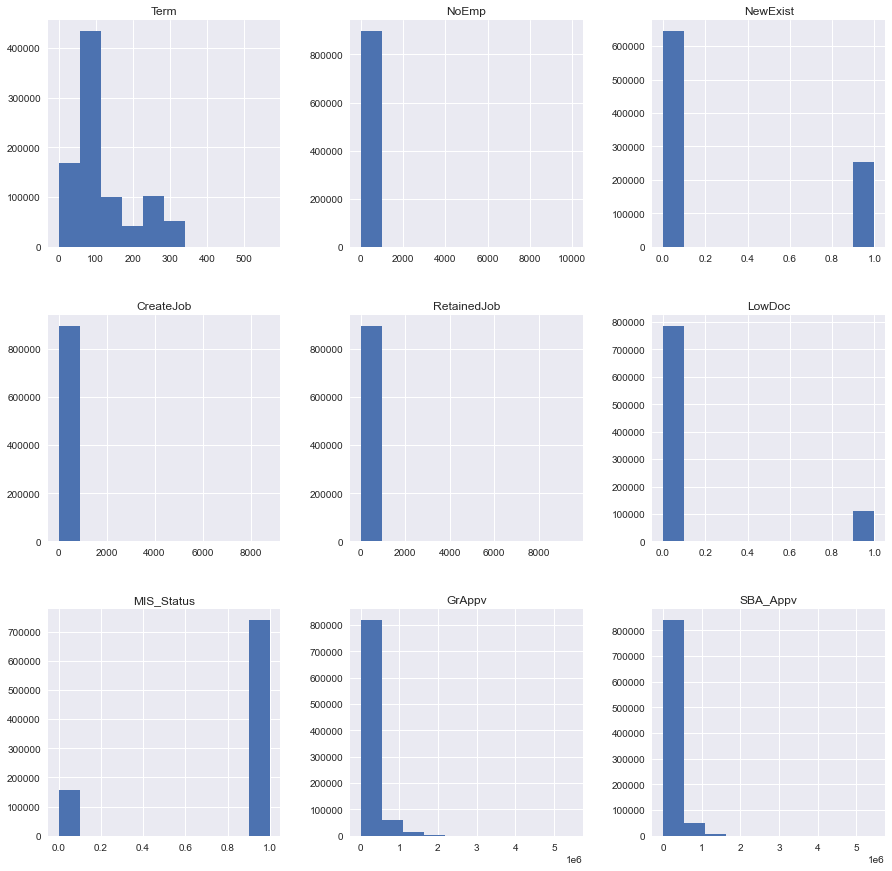

In [205]:
df.hist(figsize=(15,15))

In [206]:
# NOTE: dependent variable is skewed! (important for modeling part)

In [234]:
df.drop(columns = ['CreateJob', 'RetainedJob'],inplace=True) # plot graphics and give reason for droping

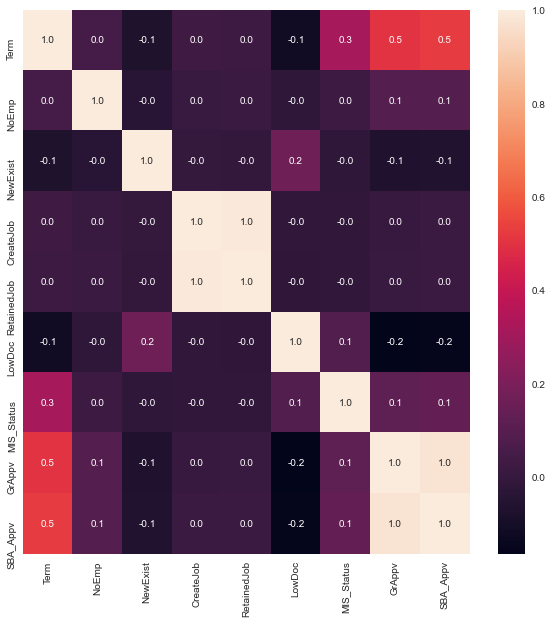

In [207]:
plt.figure(figsize = (10,10))
sns.heatmap(df.corr(), annot=True,linecolor="red",fmt= '.1f') 
plt.show()

GrAppv and SBA_Appv are perfectly lineary corelated, we should drop one of them. On the other hand, I think that amount of approved loan backed by SBA is crucial information for Loan officier. Therefore, instead of droping this column, I will create a new one: Backed_by_SBA.

In [208]:
df['Backed_by_SBA'] = df['SBA_Appv']/df['GrAppv']

In [209]:
df.drop(columns = ['SBA_Appv'], inplace=True)

In [210]:
vif = pd.DataFrame()

X = df.drop(columns = 'MIS_Status').values
vif['VIF'] = [variance_inflation_factor(X,i) for i in range(X.shape[1])]
vif.index = df.drop(columns = 'MIS_Status').columns
vif

,VIF
Term,4.710222
NoEmp,1.034962
NewExist,1.434211
CreateJob,1.002581
LowDoc,1.302272
GrAppv,2.010151
Backed_by_SBA,4.967189


Multicollinearity is still present between Term and Backed_by_SBA. However, Term is the predictor loan officer most probably would like to take into account, so I am going to keep both columns

### Saving data:

In [211]:
df.head()

,Term,NoEmp,NewExist,CreateJob,LowDoc,MIS_Status,GrAppv,Backed_by_SBA
LoanNr_ChkDgt,,,,,,,,
1000014003,84,4,1.0,0,1.0,1,60000.0,0.80
1000024006,60,2,1.0,0,1.0,1,40000.0,0.80
1000034009,180,7,0.0,0,0.0,1,287000.0,0.75
1000044001,60,2,0.0,0,1.0,1,35000.0,0.80
1000054004,240,14,0.0,7,0.0,1,229000.0,1.00


In [245]:
df.to_csv('processed_data')

Next is PyCharm.

In [244]:
df.columns

Index(['Term', 'NoEmp', 'NewExist', 'LowDoc', 'MIS_Status', 'GrAppv',
       'Backed_by_SBA'],
      dtype='object')

In [235]:
from xgboost import XGBClassifier

In [236]:
X = df.drop(columns='MIS_Status')
y = df['MIS_Status']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [237]:
xgb = XGBClassifier(max_depth=7, n_estimators=200, subsample=0.5)
xgb.fit(x_train, y_train)

C:\Users\Vanja\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:47:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [238]:
print(f1_score(xgb.predict(x_train), y_train))
print(f1_score(xgb.predict(x_test), y_test))

0.9640199054591767
0.9602596499988192


In [239]:
from sklearn.ensemble import RandomForestClassifier

In [241]:
rf = RandomForestClassifier(max_depth=18, max_features='sqrt', n_jobs=-1) # improve speed
rf.fit(x_train, y_train)

RandomForestClassifier(max_depth=18, max_features='sqrt', n_jobs=-1)

In [242]:
print(f1_score(rf.predict(x_train), y_train))
print(f1_score(rf.predict(x_test), y_test))

0.9669010372071627
0.956664270695481


In [216]:
df['CreateJob'].head()

LoanNr_ChkDgt
1000014003    0
1000024006    0
1000034009    0
1000044001    0
1000054004    7
Name: CreateJob, dtype: int64

<AxesSubplot:xlabel='MIS_Status', ylabel='CreateJob'>

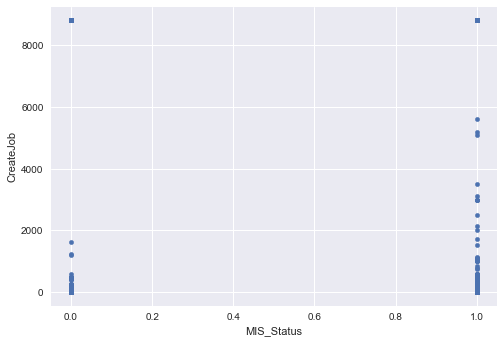

In [225]:
df.plot(x = , y= 'CreateJob', kind='scatter')

<AxesSubplot:xlabel='LoanNr_ChkDgt'>

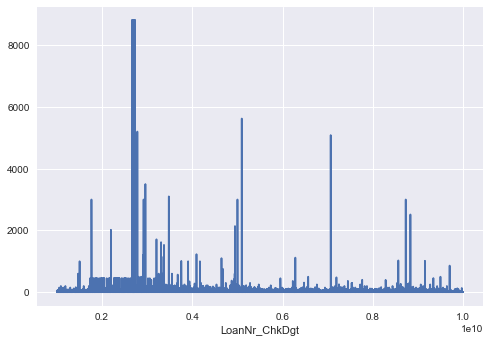

In [226]:
df['CreateJob'].plot()

In [232]:
np.sum([df['RetainedJob']==0])

KeyError: 'RetainedJob'